In [1]:
from ultralytics import YOLO
from transformers import pipeline
from huggingface_hub import login
import matplotlib.pyplot as plt
import torch
import time
import datetime

In [ ]:
# Load a model
model = YOLO("models/yolo11x.pt")
# Perform object detection on an image
result = model("images/image2.png")[0]
classes = result.names
obj_pred = result.boxes.cls
# result.save(filename="output/result.jpg")  # save to disk

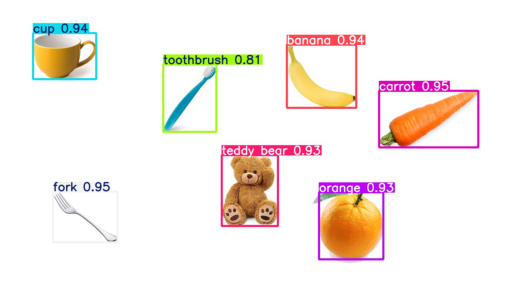

In [ ]:
img = plt.imread("images/output/result.jpg")
plt.axis('off')
plt.imshow(img)
plt.show()

In [ ]:
classes # 80 classes (total number of classed in YOLOv11 model)

In [4]:
obj_list = [classes[obj.item()] for obj in obj_pred]
obj_list

['carrot', 'fork', 'banana', 'cup', 'teddy bear', 'orange', 'toothbrush']

In [5]:
model_id = "meta-llama/Llama-3.2-1B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
pad_token_id = pipe.model.config.eos_token_id[0]

In [ ]:
clue = "It is a type of fruit that is often associated with a color."

user_prompt1 = f'''You are an assistant whose task is to identify the correct object from this list {obj_list} that aligns best with the following clue: '{clue}'
Take a moment to think about each object's properties, considering how the clue relates to them, directly or indirectly.
Then, provide only the name of the correct object as your answer. No additional explanations.
The answer is: '''

user_prompt2 = f'''From this list of objects {obj_list}, determine the object that aligns best with the following clue: '{clue}'
First, carefully evaluate the properties of each object, considering how the clue relates to them, directly or indirectly. Then provide only the name of the correct object as your answer. No additional explanations.
The answer is: '''

messages = [
    {"role": "user", "content": user_prompt1},
]

start = time.time()

# take the most probable token
outputs = pipe(
    messages,
    max_new_tokens=256,
    pad_token_id=pad_token_id,
    do_sample=False,
    
)

end = time.time()
sec = (end - start)
result_list = str(datetime.timedelta(seconds=sec))
print("Latency: ", result_list)
print("-----------------------------")
print("User Prompt: ", user_prompt1) 
# model response
print(outputs[0]["generated_text"][-1]['content'])


Latency:  0:00:00.059096
-----------------------------
User Prompt:  You are an assistant whose task is to identify the correct object from this list ['carrot', 'fork', 'banana', 'cup', 'teddy bear', 'orange', 'toothbrush'] that aligns best with the following clue: 'It is a type of fruit that is often associated with a color.'
Take a moment to think about each object's properties, considering how the clue relates to them, directly or indirectly.
Provide only the name of the correct object as your answer. No additional explanations.
The answer is: 
orange


In [7]:
selected_object = outputs[0]["generated_text"][-1]['content']

if selected_object in obj_list:
    sel_obj_idx = obj_list.index(selected_object)
else:
    print("The exact object name is not returned. So we will apply heuristics to find the closest match.")
    # find the closest match
    sel_obj_idx = 0
    max_score = 0
    for idx, obj in enumerate(obj_list):
        score = 0
        for word in selected_object.split():
            word = word.lower()
            if word in obj:
                score += 1
        if score > max_score:
            max_score = score
            sel_obj_idx = idx
    
    print("Selected Object: ", obj_list[sel_obj_idx])
    

In [10]:
sel_obj_bbox = result.boxes.xyxyn[sel_obj_idx].tolist()
sel_obj_conf = result.boxes.conf[sel_obj_idx].item()
sel_obj_bbox

[0.6233137249946594,
 0.6538925170898438,
 0.7531165480613708,
 0.8934596180915833]

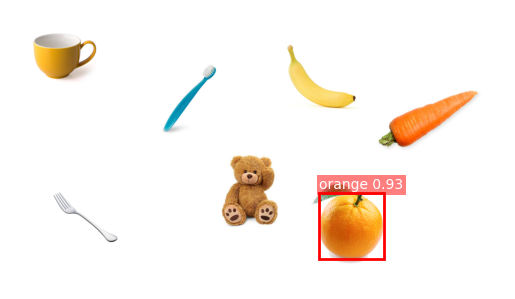

In [15]:
from utils.visualize import visualize_bbox

visualize_bbox("images/image2.png", sel_obj_bbox, obj_list[sel_obj_idx], confidence=sel_obj_conf, normalized=True, save_path="images/output/result_sel_obj.jpg")